In [2]:
!pip install -U bitsandbytes
!pip uninstall -y datasets fsspec gcsfs
!pip install datasets fsspec==2024.12.0 gcsfs==2024.12.0
!pip install transformers accelerate
!pip install peft torch
!pip install datasets


Found existing installation: datasets 3.5.0
Uninstalling datasets-3.5.0:
  Successfully uninstalled datasets-3.5.0
Found existing installation: fsspec 2024.12.0
Uninstalling fsspec-2024.12.0:
  Successfully uninstalled fsspec-2024.12.0
Found existing installation: gcsfs 2024.12.0
Uninstalling gcsfs-2024.12.0:
  Successfully uninstalled gcsfs-2024.12.0
  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached gcsfs-2024.12.0-py2.py3-none-any.whl.metadata (1.6 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
Using cached gcsfs-2024.12.0-py2.py3-none-any.whl (35 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)


c:\Users\rohit\OneDrive\Desktop\workspace\extra\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
!pip install nltk scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.1 MB 11.0 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/11.1 MB 11.1 MB/s eta 0:00:01
   ------------------- -------------------- 5.5/11.1 MB 9.4 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.1 MB 8.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.1 MB 8.4 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.1 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   -- ------------------------------------- 2.1/41.0 MB 11.3 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/41.0 MB 8.8 MB/s eta 0:00:05
   ---- ----------------------------------- 4.7/41.0 MB 8.2 MB/s eta 0:00:05
   -----

In [11]:
from datasets import load_dataset
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
dataset_name = "aboonaji/wiki_medical_terms_llam2_format"
dataset = load_dataset(dataset_name)

# Convert to Pandas DataFrame (assuming we are working with the "train" split)
df = pd.DataFrame(dataset["train"])

# Ensure the dataset has the correct text column
text_column = "text"  # Update if the dataset uses a different column name

# NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def extract_text_components(text):
    """Extracts system prompt, user instructions, and model response."""
    sys_prompt = None
    user_prompt = None
    model_resp = None

    # Extract system prompt inside <<SYS>> and <</SYS>> tags and remove the tags
    sys_match = re.search(r'<<SYS>>(.*?)<</SYS>>', text, re.DOTALL)
    if sys_match:
        sys_prompt = sys_match.group(1).strip()  # Extracted text without tags

    # Extract user prompt inside [INST] and [/INST], but remove <<SYS>> and system prompt text
    inst_match = re.search(r'\[INST\](.*?)\[/INST\]', text, re.DOTALL)
    if inst_match:
        full_inst = inst_match.group(1).strip()

        # Remove <<SYS>> section from user prompt
        user_prompt = re.sub(r'<<SYS>>.*?<</SYS>>', '', full_inst, flags=re.DOTALL).strip()

    # Extract model response outside of [INST] and [/INST] tags
    parts = re.split(r'\[/INST\]', text)
    if len(parts) > 1:
        model_resp = parts[1].strip()

    return sys_prompt, user_prompt, model_resp




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...


In [12]:

def clean_user_instructions(user_inst):
    """ Remove <<SYS>> and </SYS>> tags from the user instruction text. """
    if pd.isna(user_inst):
        return ""
    user_inst = re.sub(r'<<SYS>>.*?<</SYS>>', '', user_inst, flags=re.DOTALL)  # Remove entire <</SYS>> block
    return user_inst.strip()

def preprocess_text(text):
    """ Cleans and preprocesses text. """
    if pd.isna(text):  # Handle missing values
        return ""

    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Stopword removal & lemmatization
    return ' '.join(tokens)


In [13]:
# Apply extraction to the dataset
df[['sys_prompt', 'user_prompt', 'model_resp']] = df[text_column].apply(
    lambda x: pd.Series(extract_text_components(x))
)

In [14]:
df.head()

,text,sys_prompt,user_prompt,model_resp
0,"<s> [INST] <<SYS>> You are a helpful, respectf...","You are a helpful, respectful, and honest assi...",What is Paracetamol poisoning and explain in d...,"Paracetamol poisoning, also known as acetamino..."
1,"<s> [INST] <<SYS>> You are a helpful, respectf...","You are a helpful, respectful, and honest assi...",What is Acromegaly and explain in detail?,Acromegaly is a disorder that results from exc...
2,"<s> [INST] <<SYS>> You are a helpful, respectf...","You are a helpful, respectful, and honest assi...",What is Actinic keratosis and explain in detail?,"Actinic keratosis (AK), sometimes called solar..."
3,"<s> [INST] <<SYS>> You are a helpful, respectf...","You are a helpful, respectful, and honest assi...",What is Congenital adrenal hyperplasia and exp...,Congenital adrenal hyperplasia (CAH) is a grou...
4,"<s> [INST] <<SYS>> You are a helpful, respectf...","You are a helpful, respectful, and honest assi...",What is Adrenocortical carcinoma and explain i...,Adrenocortical carcinoma (ACC) is an aggressi...


In [18]:
# Clean user instructions by removing the <<SYS>> and </SYS>> tags
df['user_prompt'] = df['user_prompt'].apply(clean_user_instructions)
df['sys_prompt'] = df['sys_prompt'].apply(clean_user_instructions)


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:

# Preprocess extracted text fields
df['user_prompt'] = df['user_prompt'].apply(preprocess_text)
df['sys_prompt'] = df['sys_prompt'].apply(preprocess_text)
df['model_resp'] = df['model_resp'].apply(preprocess_text)


In [24]:
df.head()

,text,sys_prompt,user_prompt,model_resp
0,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,paracetamol poisoning explain detail,paracetamol poisoning also known acetaminophen...
1,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,acromegaly explain detail,acromegaly disorder result excess growth hormo...
2,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,actinic keratosis explain detail,actinic keratosis ak sometimes called solar ke...
3,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,congenital adrenal hyperplasia explain detail,congenital adrenal hyperplasia cah group autos...
4,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,adrenocortical carcinoma explain detail,adrenocortical carcinoma acc aggressive cancer...


In [25]:
# Convert text to numerical vectors using TF-IDF
# vectorizer = TfidfVectorizer(max_features=5000)
# X = vectorizer.fit_transform( df['user_prompt'] + " " + df['model_resp'])

# Convert to DataFrame
# X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Save processed data
df.to_csv('processed_data.csv', index=False)
# X_df.to_csv('vectorized_data.csv', index=False)

print("Processing complete! Data saved as 'processed_data.csv' and 'vectorized_data.csv'.")


Processing complete! Data saved as 'processed_data.csv' and 'vectorized_data.csv'.


In [26]:
df.head()

,text,sys_prompt,user_prompt,model_resp
0,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,paracetamol poisoning explain detail,paracetamol poisoning also known acetaminophen...
1,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,acromegaly explain detail,acromegaly disorder result excess growth hormo...
2,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,actinic keratosis explain detail,actinic keratosis ak sometimes called solar ke...
3,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,congenital adrenal hyperplasia explain detail,congenital adrenal hyperplasia cah group autos...
4,"<s> [INST] <<SYS>> You are a helpful, respectf...",helpful respectful honest assistant always ans...,adrenocortical carcinoma explain detail,adrenocortical carcinoma acc aggressive cancer...


In [38]:
from peft import LoraConfig, get_peft_model
from transformers import LlamaForCausalLM, LlamaTokenizer,AutoTokenizer, Trainer, TrainingArguments,AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import torch

In [29]:
df.head(1)

,sys_prompt,user_prompt,model_resp
0,helpful respectful honest assistant always ans...,paracetamol poisoning explain detail,paracetamol poisoning also known acetaminophen...


In [28]:
# Drop original text column
df = df.drop(columns=["text"])

In [33]:

# Load tokenizer
model_name = "aboonaji/llama2finetune-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    # Combine user prompt and model response for each item in the batch
    combined_texts = [
        user_prompt + " " + model_resp
        for user_prompt, model_resp in zip(examples['user_prompt'], examples['model_resp'])
    ]
    tokenized = tokenizer(
        combined_texts,  # Pass the combined texts
        padding="max_length",
        truncation=True,
        max_length=512
    )
    # Add labels for causal language modeling
    tokenized['labels'] = tokenized['input_ids'].copy()
    return tokenized


In [46]:
!pip install bitsandbytes

In [ ]:
import bitsandbytes as bnb

In [52]:

from datasets import Dataset
# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
# tokenized['labels'] = tokenized['input_ids'].copy()

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Train-Test Split (90% train, 10% test)
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]


Map: 100%|██████████| 6861/6861 [00:02<00:00, 2431.45 examples/s]


In [53]:


# Load model with 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)


In [59]:
!pip install bitsandbytes-cuda-none

ERROR: Could not find a version that satisfies the requirement bitsandbytes-cuda-none (from versions: none)
ERROR: No matching distribution found for bitsandbytes-cuda-none


In [ ]:


model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config,
    device_map="auto"
    # load_in_8bit=True,"
)


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

# Set up LoRA configuration
lora_config = LoraConfig(
    r=12,
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    num_train_epochs=5,
    per_device_train_batch_size=3,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=500,
    save_steps=500,
    fp16=True,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Start training
trainer.train()

In [ ]:

from datasets import Dataset
# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
# tokenized['labels'] = tokenized['input_ids'].copy()

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Train-Test Split (90% train, 10% test)
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

import bitsandbytes as bnb
# Load model with 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# Set up LoRA configuration
lora_config = LoraConfig(
    r=12,
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    num_train_epochs=5,
    per_device_train_batch_size=3,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=500,
    save_steps=500,
    fp16=True,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Start training
trainer.train()

In [ ]:
# Save the LoRA adapter (PEFT model)
trainer.save_model("lora_model")

# Save the tokenizer
tokenizer.save_pretrained("lora_model")

('newpath/to/save/lora_model/tokenizer_config.json',
 'newpath/to/save/lora_model/special_tokens_map.json',
 'newpath/to/save/lora_model/tokenizer.model',
 'newpath/to/save/lora_model/added_tokens.json',
 'newpath/to/save/lora_model/tokenizer.json')

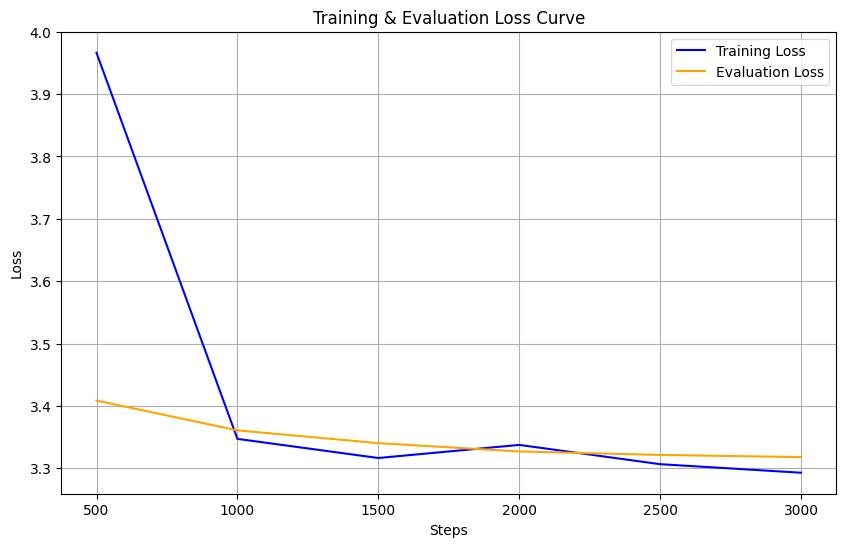

In [ ]:
import matplotlib.pyplot as plt

# Extract training log history
log_history = trainer.state.log_history

# Separate training and evaluation losses
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
steps = [log["step"] for log in log_history if "loss" in log]
eval_steps = [log["step"] for log in log_history if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color='blue')
plt.plot(eval_steps, eval_loss, label="Evaluation Loss", color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from transformers import pipeline

# Load the trained model and tokenizer
model_path = "lora_model"  # Path where your model is saved
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

# Create a text generation pipeline
chatbot_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# Define test input (simulate user query)
test_input = "[INST] what are the compunds in paracetamol? [/INST]"

# Generate response
output = chatbot_pipeline(test_input,max_length=2000,  do_sample=True, temperature=0.7)

# Print chatbot response
print("Chatbot Response:", output[0]['generated_text'])


Chatbot Response: [INST] what are the compunds in paracetamol? [/INST]  Paracetamol, also known as acetaminophen, is a widely used pain reliever and fever reducer. It is composed of the following compounds:

1. Acetaminophen: The active ingredient in paracetamol is acetaminophen, also known as N-acetyl-p-aminophenol (APAP). It is a nonsteroidal anti-inflammatory drug (NSAID) that is used to relieve pain, reduce fever, and reduce inflammation.
2. Water: Paracetamol is typically formulated as a solution containing water as the solvent.
3. Fillers: Paracetamol tablets may contain fillers such as starch, lactose, or cellulose to help maintain the proper consistency of the tablet and to provide a smooth, comfortable experience for the user.
4. Sweeteners: Some paracetamol products may contain sweeteners such as aspartame or sucrose to improve the taste of the medication.
5. Antioxidants: Paracetamol products may contain antioxidants such as sodium stannate or sodium metabisulfite to help pr